 Predict the likelihood of a user preferring a specific category

In [17]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.find_spark_home import _find_spark_home
from pyspark.sql import SparkSession
from pyspark import SparkConf, StorageLevel
import pyspark.sql.functions as F
import os
from pyspark.sql.functions import col, count, isnan, avg, max, row_number
from pyspark.sql.window import Window
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import when
import matplotlib.pyplot as plt
from dotenv import load_dotenv
load_dotenv()

print(_find_spark_home())

C:\Users\anama\anaconda3\envs\Bigdata\Lib\site-packages\pyspark


In [2]:
python_path = os.environ.get('PYTHON_PATH')
app_name = os.environ.get('APP_NAME_DEC')
hadoop_path_dec = os.environ.get('HADOOP_DEC_DATASET_PATH')
hadoop_path_nov = os.environ.get('HADOOP_NOV_DATASET_PATH')
hadoop_path = os.environ.get('HADOOP_DATASET_PATH')

In [3]:
conf = SparkConf()\
    .setMaster('local[*]')\
    .set('spark-local-dir', "C:\\spark-temp")\
    .set('spark.driver.memory', '4g')\
    .set('spark.executor.memory', '4g')\
    .set('spark.driver.maxResultSize', '2g')\
    .set('spark.pyspark.python', python_path)\
    .set('spark.pyspark.driver.python', python_path)\
    .set("spark.network.timeout","800s")\
    .set("spark.dynamicAllocation.enabled", "true")\
    .set("spark.shuffle.service.enabled", "true")\
    .set("spark.dynamicAllocation.minExecutors", "1")\
    .set("spark.dynamicAllocation.maxExecutors", "10")\
    .set("spark.dynamicAllocation.executorIdleTimeout", "60s")\

spark = SparkSession.builder.appName(app_name).config(conf=conf).getOrCreate()
sc = spark.sparkContext

for item in sc.getConf().getAll(): print(item)

('spark.executor.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false')
('spark.dynamicAllocation.minExecutors', '1')
('spark.app.id', 'local-1703940200818')
('spark.shuffle.service.enabled', 'true')
('spark.driver.port', '54981

In [4]:
df = spark.read.csv(hadoop_path + '/combined_Data/', header = True, inferSchema = True)
df.show()

+----------+----------+-------+-------+---------+-----------+--------------------+---+-----+
|event_type|product_id|  brand|  price|  user_id|   category|             product|day|month|
+----------+----------+-------+-------+---------+-----------+--------------------+---+-----+
|      view|   3600661|samsung| 308.86|572466808| appliances|      kitchen.washer| 17|   11|
|      view|   1005136|  apple|2007.52|518751528|electronics|          smartphone| 14|   11|
|      view|   1401577|  apple| 1441.2|520999069|  computers|             desktop| 23|   11|
|      view|   1005159| xiaomi| 200.39|517708505|electronics|          smartphone| 21|   11|
|      cart|   1004766|samsung| 251.82|523183378|electronics|          smartphone| 22|   11|
|      view| 100003580| optima| 193.03|519133244| appliances|kitchen.refrigera...| 15|   11|
|      view|   1801226|  yasin| 115.75|568638630|electronics|            video.tv| 20|   11|
|      view|   1004858|samsung|  126.0|516835814|electronics|         

In [5]:
# Calculate interaction and purchase counts for categories instead of brands
category_interaction_count = df.groupBy("user_id", "category").count().withColumnRenamed("count", "interaction_count")
category_purchase_count = df.filter(col("event_type") == "purchase").groupBy("user_id", "category").count().withColumnRenamed("count", "purchase_count")

In [6]:
df = df.join(category_interaction_count, ["user_id", "category"], "left")
df = df.join(category_purchase_count, ["user_id", "category"], "left")

In [7]:
# Calculate average price interaction and recency for categories
avg_price_interaction = df.groupBy("user_id", "category").agg(avg("price").alias("avg_price_per_category"))
recency_interaction = df.groupBy("user_id", "category").agg(max("day").alias("last_interaction_day"))


In [8]:
# Join additional calculated features
df = df.join(avg_price_interaction, ["user_id", "category"], "left")
df = df.join(recency_interaction, ["user_id", "category"], "left")

In [9]:
df = df.na.fill({
    'purchase_count': 0,
    'interaction_count': 0,
    'avg_price_per_category': 0,
    'last_interaction_day': 0
})

In [10]:
# Encode the categorical 'category' variable
category_indexer = StringIndexer(inputCol="category", outputCol="categoryIndex")
df = category_indexer.fit(df).transform(df)
encoder = OneHotEncoder(inputCols=["categoryIndex"], outputCols=["categoryVec"])
df = encoder.fit(df).transform(df)

In [11]:
assembler = VectorAssembler(
    inputCols=[
        "interaction_count",
        "purchase_count",
        "avg_price_per_category",
        "categoryVec",
        "last_interaction_day"
    ],
    outputCol="features"
)
df = assembler.transform(df)

In [12]:
# Define the target variable for most preferred category
windowSpec = Window.partitionBy("user_id").orderBy(col("purchase_count").desc())
df = df.withColumn("preference_rank", row_number().over(windowSpec))
df = df.withColumn("label", when(col("preference_rank") == 1, 1).otherwise(0))

In [13]:
# Split data, train model, make predictions
train, test = df.randomSplit([0.8, 0.2], seed=42)

In [14]:
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=10)
model = rf.fit(train)
predictions = model.transform(test)

In [15]:
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
print("Area Under ROC: ", roc_auc)

Area Under ROC:  0.7727586769558228


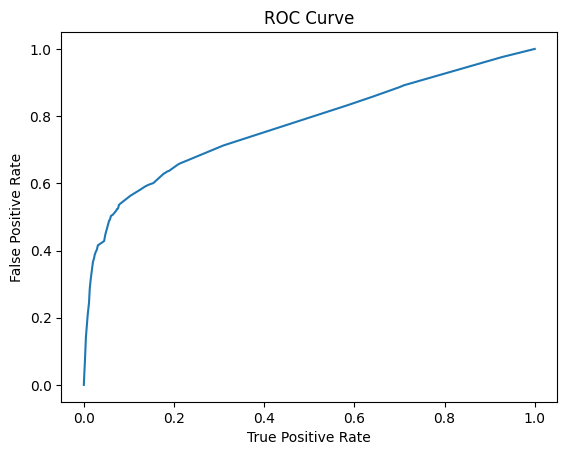

In [18]:
trainingSummary = model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()